## Bayesian rate consistency model with PriorVAE


In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
numpyro.set_host_device_count(4)
numpyro.enable_x64()

import jax
import optax
from jax import random
import jax.numpy as jnp
import pyreadr
import pandas as pd
import os

from priorCVAE.models import MLPDecoder
from priorCVAE.priors import Matern32, Matern52, SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.utility import load_model_params

from bayes_rate_consistency.model import simulation_model_gp
from bayes_rate_consistency.mcmc import run_mcmc
from bayes_rate_consistency.simulation import sim_make_mcmc_data

import jax.config as config
config.update("jax_enable_x64", True)

In [2]:
# Configuration dictionary
args = {
        "n_data": 44,
        "batch_size": 500,
        "num_iterations": 5000,
        "data_dim": 2,

        "input_dim" : 1936,
        "hidden_dim": 80,
        "latent_dim": 30,

        "n_test": 5000,
        "kernel": "matern52",
        "ls": 0.2
       }
args['model_path'] = f"weights/vae_{args['input_dim']}_{args['num_iterations']}_{args['data_dim']}d_{args['kernel']}_{args['ls']}"

In [3]:
args['model_path'] = "weights/vae_1936_6000_2d_matern32_0.5"

## Generate data

In [4]:
kernel = Matern32(lengthscale=0.5)

gp_set = GPDataset(n_data=args["n_data"], kernel=kernel, sample_lengthscale=False, x_dim=2)  
# sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=args['batch_size'])
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=20)

## Load the model


In [5]:
decoder_params = load_model_params(args["model_path"])["decoder"]

In [6]:
from bayes_rate_consistency.decoder.decoder import MLPDecoder

decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (args["n_test"], args["latent_dim"]))

key = jax.random.PRNGKey(rnd.randint(0, 9999))
key, e_rng, d_rng = jax.random.split(key, 3)

vae_samples = decoder.apply({'params': decoder_params}, z)             


vae_samples_reshaped = vae_samples.reshape((args["n_test"], gp_set.n_data, gp_set.n_data))

# fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"})

# ax.plot_surface(gp_set.x1, gp_set.x2, vae_samples_reshaped[40], cmap=coolwarm)

# ax.set_xlabel('$x1$')
# ax.set_ylabel('$x2$')
# ax.set_zlabel('$y=f_{VAE}(x)$')
# ax.set_title('Examples of decoder output')

# plt.show()

## Bayesian rate consistency model

In [7]:
root_dir = "/Users/eric/acse/irp/priorCVAE-bayes-rate-consistency/"
datasets_dir = "/Users/eric/acse/irp/priorCVAE-bayes-rate-consistency/data/my_simulations/datasets"
data_dir = "inCOVID_2000_COVIMOD"
data_path = os.path.join(datasets_dir, data_dir, "data_1.rds")
data_path

'/Users/eric/acse/irp/priorCVAE-bayes-rate-consistency/data/my_simulations/datasets/inCOVID_2000_COVIMOD/data_1.rds'

### Load Data

In [8]:
data = pyreadr.read_r(data_path)[None]


In [9]:
def categorize_age_strata(data):
    age_order = ['6-9', '10-14', '15-19', '20-24', '25-34', '35-44', '45-49']
    # Convert the 'alter_age_strata' column to a categorical type with the custom order
    data['alter_age_strata'] = pd.Categorical(data['alter_age_strata'], categories=age_order, ordered=True)
    return data
data = categorize_age_strata(data)

In [10]:
A = 44
strata_scheme = 'COVIMOD'
mcmc_data = sim_make_mcmc_data(data, strata_scheme, A)

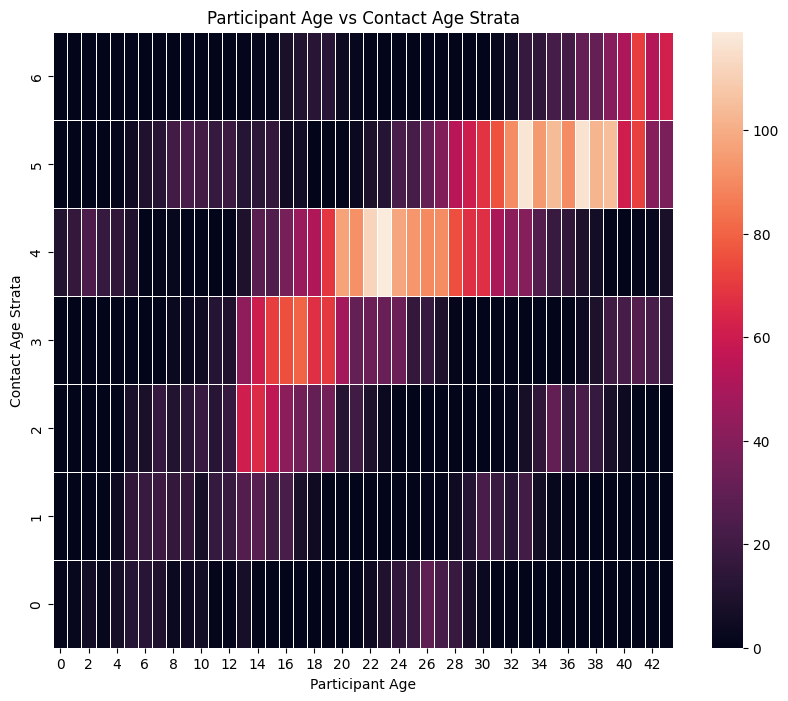

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
plt.figure(figsize=(10,8))  # Set the figure size
sns.heatmap(mcmc_data['Y_MF'].T, annot=False, fmt="d", linewidths=.5)

# Customize the plot
plt.title('Participant Age vs Contact Age Strata')
plt.xlabel('Participant Age')
plt.ylabel('Contact Age Strata')

plt.gca().invert_yaxis()

# Display the plot
plt.show()


## MCMC Inference

In [12]:

args = {
        # architecture
        "input_dim" : 1936,
        "hidden_dim": 80,
        "latent_dim": 30,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 100,
        "num_samples": 100,
        "num_chains": 1,
        "thinning": 1,
       }

In [13]:
args['logP'] = mcmc_data['log_P_F']
args['logN'] = mcmc_data['log_N_M']
args['z_dim'] = 30
args['map_age_to_strata'] = mcmc_data['map_age_to_strata']
args['Y'] = mcmc_data['Y_MF']

# 1e-13

In [14]:
A = mcmc_data["A"]
x = jnp.linspace(0, 1, A)
x1, x2 = jnp.meshgrid(x, x)
x = jnp.stack([x1, x2], axis=-1)
x1 = x1
x2 = x2
x = x.reshape([A ** 2, 2])
args['kernel'] = Matern52(0.5)(x,x)
args['size'] = x.shape[0]

In [15]:
rng_key = random.PRNGKey(1)
rng_key, rng_key_post, rng_key_predict, rng_key_draw = jax.random.split(rng_key, 4)

mcmc, mcmc_samples, t_elapsed = run_mcmc(rng_key_post, simulation_model_gp, args, y=mcmc_data['Y_MF'])

sample: 100%|██████████| 200/200 [05:47<00:00,  1.74s/it, 1023 steps of size 1.54e-03. acc. prob=0.91]


In [16]:
import arviz as az
samples_vae_az = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

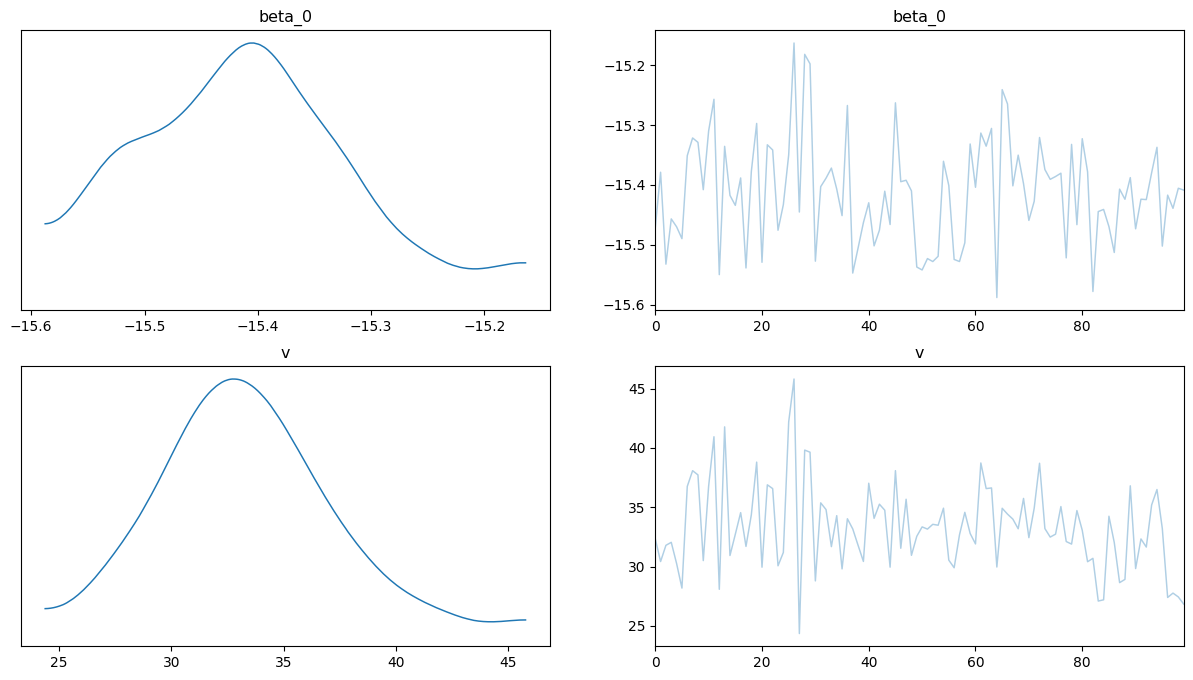

In [17]:
az.plot_trace(samples_vae_az, var_names = ("beta_0", "v"), figsize = (15, 8), compact = False)

### Posterior predictive checks

In [18]:
args['Y'] = None
predictive = Predictive(simulation_model_gp, mcmc_samples.copy())
predictions_vae = predictive(rng_key_predict, args)

In [19]:
numpyro_data = az.from_numpyro(mcmc, posterior_predictive=predictions_vae)
numpyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [20]:
y_strata = mcmc_data['Y_MF']
yhat_strata = jnp.median(predictions_vae['yhat_strata'],axis=0)
# yhat_strata

In [21]:
np.mean(np.abs(yhat_strata-y_strata))

16.251623376623378

In [22]:
# def sim_posterior_predictive_check(predictions, mcmc_data):
#     y_strata = mcmc_data['Y_MF']
#     yhat_strata = predictions['yhat_strata']

#     ci_lower = jnp.quantile(yhat_strata, 0.025, axis=0)
#     ci_upper = np.quantile(yhat_strata, 0.975, axis=0)
#     in_range = (ci_lower <= y_strata) & (y_strata <= ci_upper)
#     valid_idx = np.where(in_range)
#     proportion = valid_idx[0].shape[0]/y_strata.size
#     return proportion

# sim_posterior_predictive_check(predictions_vae, mcmc_data)

def sim_posterior_predictive_check(y_strata, yhat_strata):
    ci_lower = yhat_strata.quantile(0.025, dim=["chain", "draw"]).values
    ci_upper = yhat_strata.quantile(0.975, dim=["chain", "draw"]).values

    in_range = (ci_lower <= y_strata) & (y_strata <= ci_upper)
    num_valid = jnp.where(in_range)[0].size
    proportion = num_valid/y_strata.size
    return proportion

sim_posterior_predictive_check(y_strata, numpyro_data.posterior_predictive['yhat_strata'])

# type(numpyro_data.posterior_predictive['yhat_strata'].quantile(0.975, dim=["chain", "draw"]).values)

0.9577922077922078

### Recover contact intensities

In [23]:
posterior_samples = mcmc_samples.copy()
P = mcmc_data['P_F']
P = np.tile(P, (44, 1))

log_contact_rate = posterior_samples['log_contact_rate']

m_pred = jnp.exp(jnp.quantile(log_contact_rate, 0.5, axis=0)).reshape(44,44) * P

In [24]:
m = data[
    (data['gender'] == 'Male') & 
    (data['alter_gender'] == 'Female')
].sort_values(by=['age', 'alter_age']).cntct_intensity.to_numpy().reshape(44,44)

In [25]:
mae = np.mean(np.abs(m - m_pred))
mae

0.12878499426646603

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Simulated intensities'}>)

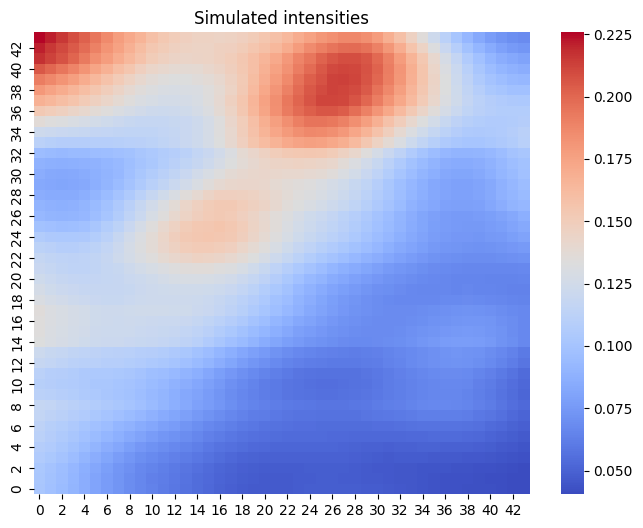

In [35]:
def plot_heatmap(matrix: jnp.ndarray, title='', figsize=(8,6)):
    """ Plot a heatmap of the input matrix. """

    # matrix[0, 42:44] = 100
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.heatmap(matrix, annot=False, fmt='g', cmap='coolwarm', ax=ax)
    ax.set_title(title)
    plt.gca().invert_yaxis()
    return fig, ax

plot_heatmap(m_pred.T, title='Simulated intensities')

In [ ]:
n_grid = 3
Xplots = jnp.linspace(0, 1, n_grid)
Xplot1, Xplot2, Xplot3 = jnp.meshgrid(Xplots, Xplots, Xplots)
Xplot = jnp.stack([Xplot1, Xplot2, Xplot3], axis=-1)
Xplot = Xplot.reshape([n_grid ** 3, 3])

In [ ]:
Matern52()(Xplot,Xplot)

Array([[1.        , 0.82864914, 0.52399411, 0.82864914, 0.70249576,
        0.45830791, 0.52399411, 0.45830791, 0.31728336, 0.82864914,
        0.70249576, 0.45830791, 0.70249576, 0.60372976, 0.40338859,
        0.45830791, 0.40338859, 0.28316327, 0.52399411, 0.45830791,
        0.31728336, 0.45830791, 0.40338859, 0.28316327, 0.31728336,
        0.28316327, 0.20532088],
       [0.82864914, 1.        , 0.82864914, 0.70249576, 0.82864914,
        0.70249576, 0.45830791, 0.52399411, 0.45830791, 0.70249576,
        0.82864914, 0.70249576, 0.60372976, 0.70249576, 0.60372976,
        0.40338859, 0.45830791, 0.40338859, 0.45830791, 0.52399411,
        0.45830791, 0.40338859, 0.45830791, 0.40338859, 0.28316327,
        0.31728336, 0.28316327],
       [0.52399411, 0.82864914, 1.        , 0.45830791, 0.70249576,
        0.82864914, 0.31728336, 0.45830791, 0.52399411, 0.45830791,
        0.70249576, 0.82864914, 0.40338859, 0.60372976, 0.70249576,
        0.28316327, 0.40338859, 0.45830791, 0.3172

In [ ]:
if x_dim == 3:
        x1, x2, x3 = jnp.meshgrid(x, x, x)
        x = jnp.stack([x1, x2, x3], axis=-1)

x = x.reshape([n_data ** x_dim, x_dim])